# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 7: $k$-NN Classification and Imputation

**Harvard University**<br>
**Fall 2019**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Kaxiras.  <br>
**Contributors:** Kevin Rader

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals 
In this lab, we'll explore classification models to predict the health status of survey respondents and be able to build a classification decision boundary to predict the resultsing unbalanced classes.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - $k$-NN Regression
 - ROC curves and classification metrics
- Be able to optimize some loss function based on misclassification rates
- Be able to impute for missing values
- Be comfortable in the different approaches in handling missingness

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# %matplotlib inline
import seaborn.apionly as sns

/home/dev15/anaconda3/envs/pandai/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/dev15/anaconda3/envs/pandai/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/dev15/anaconda3/envs/pandai/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/dev15/anaconda3/envs/pandai/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/dev15/anaconda3/envs/pandai/lib/python3.7/

## Part 1:  General Social Survey Data + EDA

The dataset contains a subset of data from the General Social Survey (GSS) that is a bi-annual survey of roughly 2000 Americans.  We will be using a small subset of the approx 4000 questions they ask.  Specifically we'll use:  

- **id:** respondant's unique ID
- **health:** self-reported health level with 4 categories: poor, fair, good, excellent
- **partyid:** political party affiliation with categories dem, rep, or other
- **age:** age in years
- **sex:** male or female
- **sexornt:** sexual orientation with categories hetero, gay, or bisexual/other
- **educ:** number of years of formal education (capped at 20 years)
- **marital:** marital status with categories married, never married, and no longer married
- **race:** with categories black, white, and other
- **income:** in thousands of dollars

Our goal is to predict whether or not someone is in **poor health** based on the other measures.

For this task, we will exercise our normal data science pipeline -- from EDA to modeling and visualization. In particular, we will show the performance of 2 classifiers:

- Logistic Regression
- $k$-NN Regression

So without further ado...

### EDA

Do the following basic EDA (always good ideas):
1. Determine the dimensions of the data set.
2. Get a glimpse of the data set.
3. Calculate basic summary/descriptive statistics of the variables.

We also ask that you do the following:
4. Create a binary called `poorhealth`.  
5. Explore the distribution of the responses, `health` and `poorhealth`, 
6. Explore what variables may be related to whether or not some is of poor health.  

In [3]:
gssdata = pd.read_csv("data/gsshealth18.csv")

#####
# You code here: EDA
# 1. Determine the dimensions of the data set.
# 2. Get a glimpse of the data set.
# 3. Calculate basic summary/descriptive statistics of the variables.
####
print(gssdata.shape)
gssdata.head()

(1569, 10)


,id,health,partyid,age,sex,sexornt,educ,marital,race,income
0,1,good,rep,43.0,male,bisexual/other,14.0,never married,white,NaN
1,2,excellent,dem,74.0,female,hetero,10.0,no longer married,white,NaN
2,5,excellent,rep,71.0,male,hetero,18.0,no longer married,black,NaN
3,6,good,dem,67.0,female,bisexual/other,16.0,no longer married,white,NaN
4,7,good,dem,59.0,female,bisexual/other,13.0,no longer married,black,18.75


In [4]:
gssdata.describe()

,id,age,educ,income
count,1569.000000,1567.000000,1567.000000,908.000000
mean,1182.409815,48.135290,13.785578,49.367566
std,675.573679,18.234273,2.933485,45.127528
min,1.000000,18.000000,0.000000,0.500000
25%,601.000000,33.000000,12.000000,18.750000
50%,1188.000000,46.000000,14.000000,37.500000
75%,1769.000000,62.000000,16.000000,67.500000
max,2348.000000,89.000000,20.000000,200.000000


In [5]:
gssdata.isna().sum()

id           0
health       0
partyid      0
age          2
sex          0
sexornt      0
educ         2
marital      2
race         0
income     661
dtype: int64

In [14]:
logit = LogisticRegression(C=1000000)
logit.fit(I_train, y_train) 
print(logit.score(I_test,y_test))
logit.coef_
# Expected as there are still NaNs in the dataset

ValueError: could not convert string to float: 'white'

In [15]:
pd.crosstab(gssdata['health'], gssdata['sex'])

sex,female,male
health,,
excellent,198,161
fair,188,167
good,442,329
poor,44,40


(array([771.,   0.,   0., 359.,   0.,   0.,  84.,   0.,   0., 355.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

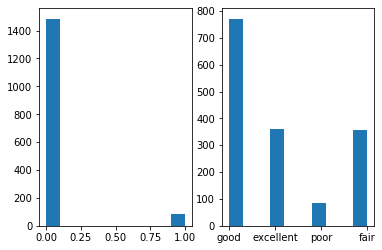

In [7]:
#####
# You code here: EDA
# 4. Create a binary called `poorhealth`.  
# 5. Explore the distribution of the responses, `health` and `poorhealth`, 
# 6. Explore what variables may be related to whether or not some is of poor health.
####
poorhealth = (gssdata["health"]=="poor").map(lambda x: 1 if x is True else 0)
plt.subplot(121)
plt.hist(poorhealth)
plt.subplot(122)
plt.hist(gssdata["health"])

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


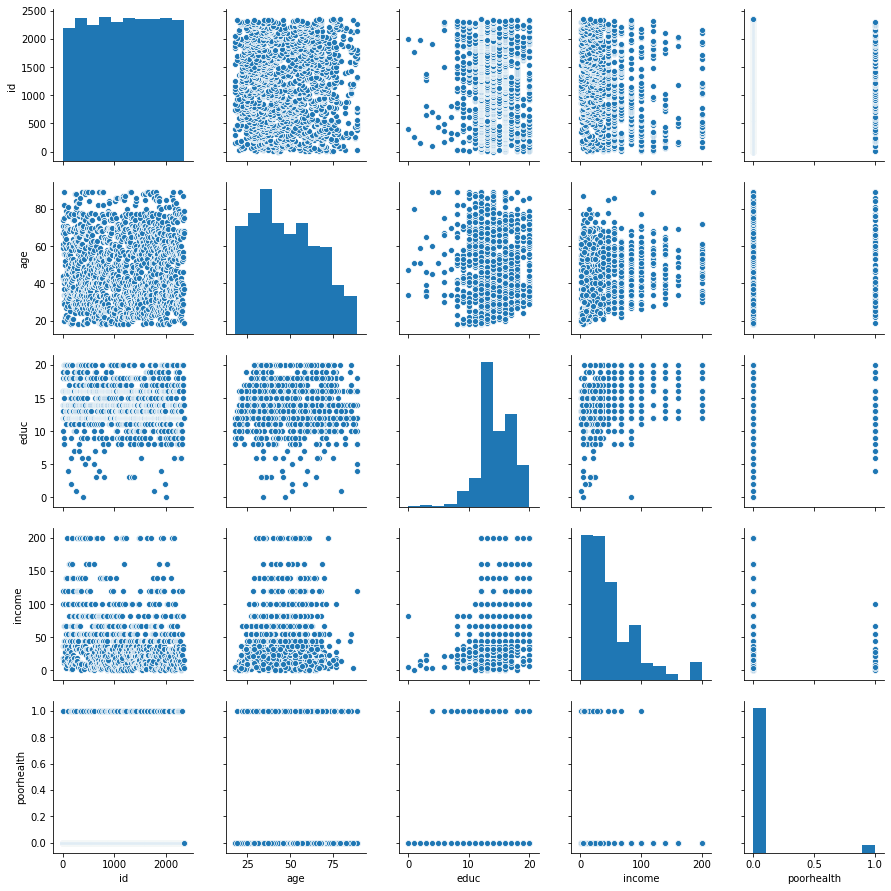

In [19]:
sns.pairplot(gssdata)

**Question**: What classification accuracy could you achieve if you simply predicted `poorhealth` without a model?  What classification accuracy would you get if you were to predict the multi-class `health` variable? Is accuracy the correct metric?

*your answer here*
Probably 30%. Less than 10%. Yes.

### Data Cleaning - Basic Handling of Missingness

Let's begin by fitting an unregularized logistic regression model to predict poor health based on all the other predictors in the model and three $k$-NN models with $k=5,10,20$.

First we need to do a small amount of data clean-up.  
1. Determine the amount of missingness in each variable.  If there is *a lot*, we will drop the variable from the predictor set (not quite yet).  If there is a little, we will impute.
2. Drop any variables with lots of missingnes (in a new data set).
3. Do simple imputations for variables with a little bit of missingness.
4. Create dummies for categorical predictors.


In [8]:
#########
# 1. Determine the amount of missingness in each variable. 
# Use is.na() in combination with .sum()
########

# Your code here
gssdata.isna().sum(axis=0)

id           0
health       0
partyid      0
age          2
sex          0
sexornt      0
educ         2
marital      2
race         0
income     661
dtype: int64

In [9]:
#######
# And then build your predictor set
# 2. Drop any variables with lots of missingnes (in a new data set).
# 3. Do simple imputations for variables with a little bit of missingness.
# 4. Create dummies for categorical predictors.
#########
X = gssdata[['partyid','age','sex','sexornt','educ','marital','race']]

values = {'age': X['age'].median(),
          'educ': X['educ'].median(),
          'marital': X['marital'].value_counts().index[0]}

X = X.fillna(value=values)

X.isna().sum(axis=0)

partyid    0
age        0
sex        0
sexornt    0
educ       0
marital    0
race       0
dtype: int64

In [11]:
#create dummies (lots of ways to do it, two ways will be in the solutions
X = pd.get_dummies(X, prefix="is", 
               columns=['partyid', 'sex', 'sexornt', 'marital', 'race'],
              drop_first=True)

print(X.shape)

(1569, 11)


## Part 2:  Fit Basic Models

In this section we ask you to:

1. Split the data into 70-30 train-test splits (use the code provided...should have been done before EDA :( )
2. Fit an unregularize logistic regression model to predict `poorhealth` from all predictors except income.
    
    2b. If you have time: use 'LogisticRegressionCV' to find a well-tuned L2 regularized model.
    
    
3. Fit $k$-NN classification models with $k=1,15,25$ to predict `poorhealth` from all predictors except income.
4. Report classification accuracy on both train and test set for all models.

In [15]:
def preprocess(df):
    
    X = df.drop(columns=["id", "health", "income"])
    
    values = {'age': X['age'].median(),
          'educ': X['educ'].median(),
          'marital': X['marital'].value_counts().index[0]}
    X = X.fillna(value=values)
    
    X = pd.get_dummies(X, prefix="is", 
               columns=['partyid', 'sex', 'sexornt', 'marital', 'race'],
              drop_first=True)
    
    return X

In [16]:
#######
# Use the following train_test_split code to: 
# 1. Split the data into 70-30 train-test splits
#######
from sklearn.model_selection import train_test_split
gss_x = preprocess(gssdata)

itrain, itest = train_test_split(range(len(gssdata)), train_size=0.70)

x_train = gss_x.iloc[itrain]
x_test = gss_x.iloc[itest]

y_train = poorhealth.iloc[itrain]
y_test = poorhealth.iloc[itest]

In [17]:
######
# 2. Fit an unregularize logistic regression model to predict `poorhealth` 
#    from all predictors except income.
# 2b. If you have time: use 'LogisticRegressionCV' to find a well-tuned L2 regularized model.
# 3. Fit $k$-NN classification models with k=1,15,25 to predict `poorhealth` 
#    from all predictors except income.
######
from sklearn.neighbors import KNeighborsClassifier

LRmodel = LogisticRegressionCV(solver='lbfgs', max_iter=1000).fit(x_train, y_train)

Kmodels = []
for k in [1,15,25]:
    Kmodels.append(KNeighborsClassifier(k).fit(x_train, y_train))

In [18]:
######
# 4. Report classification accuracy on both train and test set for all models.
######
print(LRmodel.score(x_test, y_test))
for kmodel in Kmodels:
    print(kmodel.score(x_test, y_test))

0.9447983014861996
0.8853503184713376
0.9447983014861996
0.9447983014861996


## Part 3: Evaluate Models via Confusion matrices and ROC Curves

In this part we ask that you:
1. Plot the histograms of predicted probabilities for your favorite model from above
2. Create the confusion matrices for (a) the default threshold for classification and (b) a well-chosen threshold for classification to balance errors more equally.
3. Make ROC curves to evaluate a model's overall useability.
4. Use the ROC curves to select a threshold to balance the two types of errors.

As a reminder of Confustion Matrices:
- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](confusionmatrix_360.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



(array([216., 237., 153., 139., 122., 103.,  67.,  27.,  31.,   3.]),
 array([0.03698094, 0.04218133, 0.04738171, 0.0525821 , 0.05778249,
        0.06298288, 0.06818326, 0.07338365, 0.07858404, 0.08378443,
        0.08898482]),
 <a list of 10 Patch objects>)

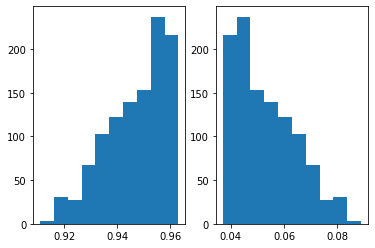

In [19]:
#####
# 1. Plot the histograms of predicted probabilities on train for your favorite 
#    model from above
#####
plt.subplot(121)
plt.hist(LRmodel.predict_proba(x_train)[:,0])
plt.subplot(122)
plt.hist(LRmodel.predict_proba(x_train)[:,1])

In [20]:
#####
#  2. Create the confusion matrices for (a) the default threshold for classification and 
#     (b) a well-chosen threshold for classification to balance errors more equally.
#####

from sklearn.metrics import confusion_matrix

# this function may help to manually make confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

confusion_matrix(y_train, LRmodel.predict(x_train))

array([[1040,    0],
       [  58,    0]])

In [25]:
confusion_matrix(y_train, t_repredict(LRmodel, 0.075, x_train))

array([[990,  50],
       [ 53,   5]])

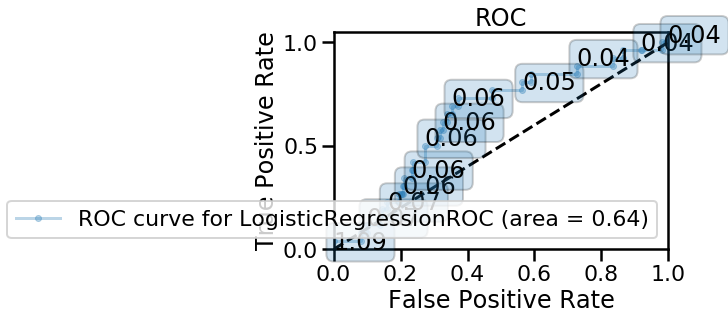

In [26]:
#####
# 3. Make ROC curves to evaluate a model's overall useability.
#####

from sklearn.metrics import roc_curve, auc

# a function to make 'pretty' ROC curves for this model
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

sns.set_context("poster")
make_roc("LogisticRegressionROC", LRmodel, y_test, x_test)

4. Use the ROC curves to select a threshold to balance the two types of errors.

*your answer here*
0.075

## Part 4: Imputation

In this part we ask that you explore the effects of imputation:
1. Plot the histogram of `income`.
2. Create a new variable `income_imp` that imputes the median or mean income for all the missing values and plot the histogram for this new variable.
3. Compare the histograms above.


4. Update your `poorhealth` prediction model(s) by incorporating `income_imp`. 
5. Compare the accuracy of this new model.


And if there is time:
       
6. Create a new variable `income_imp2` that imputes the value via a model.
7. Update your `poorhealth` prediction model(s) by incorporating `income_imp2`. 
8. Compare the accuracy of this newest model.

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


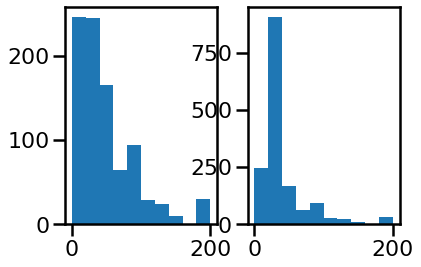

In [27]:
#####
# 1. Plot the histogram of `income`.
# 2. Create a new variable `income_imp` that imputes the median or 
#    mean income for all the missing values and plot the histogram for this new variable.
#####
plt.subplot(121)
plt.hist(gssdata.income);
income_imp = gssdata.income.fillna(gssdata.income.median())
plt.subplot(122)
plt.hist(income_imp);

3. Compare the histograms above.

*your answer here*

In [28]:
#####
# 4. Update your `poorhealth` prediction model(s) by incorporating `income_imp`. 
# 5. Calculate and compare the accuracy of this new model.
# And if there is time:
# 6. Create a new variable `income_imp2` that imputes the value via a model.
# 7. Update your `poorhealth` prediction model(s) by incorporating `income_imp2`. 
# 8. Calculate and compare the accuracy of this newest model.
#####
x_train["income_imp"] = income_imp[itrain]
x_test["income_imp"] = income_imp[itest]
LRmodel = LogisticRegressionCV(solver='lbfgs', max_iter=10000).fit(x_train, y_train)

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


5 and 8. Compare the accuracies.

*your answer here* NO CHANGE

In [29]:
LRmodel.score(x_test, y_test)

0.9447983014861996

### Using model to impute income

In [4]:
from sklearn.linear_model import RidgeCV

In [34]:
def preimpute(df):    
    values = {'age': df['age'].median(),
          'educ': df['educ'].median(),
          'marital': df['marital'].value_counts().index[0]}
    df = df.fillna(value=values)
    
    df = pd.get_dummies(df, prefix="is", 
               columns=['partyid', 'sex', 'sexornt', 'marital', 'race'],
              drop_first=True)
    y = df.income
    df["poorhealth"] = (df["health"]=="poor").map(lambda x: 1 if x is True else 0)
    X = df.drop(columns=["id", "income", "health"])
    return X, y

In [35]:
x_impute, y_impute = preimpute(gssdata)

In [58]:
# Find Not NaNs for training
train_notnulls = y_impute.iloc[itrain].notnull()
x_train_notnulls = x_impute.iloc[itrain][train_notnulls]
y_train_notnulls = y_impute.iloc[itrain][train_notnulls]

In [59]:
# Fitting a Linear Regression
imputer = RidgeCV().fit(x_train_notnulls, y_train_notnulls)

In [60]:
# MSE is the variance
sigma2_hat = sk.metrics.mean_squared_error(y_train_notnulls,imputer.predict(x_train_notnulls))

In [71]:
# Normally-distributed noise will be added to impute values
e_miss = np.random.normal(loc=0,scale=np.sqrt(sigma2_hat),size=sum(y_impute.isna()))

In [78]:
# Impute!
all_nulls = y_impute.isna()
y_impute[all_nulls] = imputer.predict(x_impute[all_nulls]) + e_miss

In [81]:
# Replace into DataFrame
gssdata.income = y_impute

In [83]:
def preprocess_2(df):
    
    X = df.drop(columns=["id", "health"])
    
    values = {'age': X['age'].median(),
          'educ': X['educ'].median(),
          'marital': X['marital'].value_counts().index[0]}
    X = X.fillna(value=values)
    
    X = pd.get_dummies(X, prefix="is", 
               columns=['partyid', 'sex', 'sexornt', 'marital', 'race'],
              drop_first=True)
    
    return X

In [84]:
gss_x = preprocess_2(gssdata)
x_train = gss_x.iloc[itrain]
x_test = gss_x.iloc[itest]

LRmodel = LogisticRegressionCV(solver='lbfgs', max_iter=1000).fit(x_train, y_train)
print(LRmodel.score(x_test, y_test))

0.9447983014861996
